# Air Quality Prediction Challenge

# Introduction:
The fight for clean air is a global battle, and Africa is a crucial battleground. This project tackles air pollution head-on, leveraging the power of satellite imagery and the CatBoost algorithm to predict PM2.5 levels in eight key African cities.

# Why PM2.5?

PM2.5, particulate matter with a diameter less than 2.5 micrometers, is a silent killer. It infiltrates our lungs, impacting respiratory health and posing a significant threat to public well-being. Accurately predicting PM2.5 concentrations empowers us to take proactive measures – from issuing health advisories to implementing pollution control strategies.

# Our Data Arsenal:

We'll be wielding a custom dataset specifically designed for this mission, focusing on eight African cities across seven african countries:

Kampala, Uganda
Lagos, Nigeria
Accra, Ghana
Nairobi, Kenya
Yaoundé, Cameroon
Bujumbura, Burundi
Kisumu, Kenya
Gulu, Uganda

This dataset is a multifaceted weapon, combining the following:

- PM2.5 measurements: The ground truth we're aiming to predict.
Satellite-derived Aerosol Optical Depth (AOD) data: A powerful indicator of atmospheric particulate matter.
- Information on various atmospheric pollutants: Data from Sentinel-5P satellites, including Sulphur Dioxide (SO2), Carbon Monoxide (CO), and others, which can provide clues about pollution sources and interactions.
For more details about Sentinel-5P data, you can refer to [https://developers.google.com/earth-engine/datasets/catalog/sentinel-5p].

# Training and Testing:

To ensure our model can generalize effectively, the dataset is divided into two parts , training and validation .


#The CatBoost Advantage:

CatBoost, known for its efficiency and ability to handle diverse data types, will be our weapon of choice in building a predictive model. By leveraging Group K-Fold cross-validation, we'll ensure the model performs well on new data, not just the training set.

# Data Preprocessing:
We'll meticulously examine the data, identifying and handling missing values, and potentially performing feature scaling to ensure variables are on a similar scale.

#Feature Engineering:
 We'll delve deeper, crafting informative features from the satellite data and other available information. This will help the model learn complex relationships between PM2.5 and various factors.

#Model Training and Evaluation:
We'll train the CatBoost model and rigorously evaluate its performance using metrics like RMSE. This will determine its accuracy in predicting PM2.5 levels.

# Feature Importance Analysis:

By analyzing the model's feature importances, we'll identify the satellite observations and pollutants that have the most significant influence on PM2.5 concentrations. This will provide invaluable insights into the factors shaping air quality in these cities.

# Goal:

This project aims to build a reliable model for predicting PM2.5 levels using satellite data. Ultimately, this model can serve as a cornerstone for environmental monitoring and air quality management in these African cities, paving the way for a cleaner, healthier future.



In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


## Importing Libraries

First, we need to import the necessary libraries.

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import catboost as catt
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 500
pd.options.display.max_rows = 500

## Configuration and Data Loading

Define configuration and load the train and test datasets.

In [3]:
class Config:
    path = "/kaggle/input/air-quality-data-set/"
    id_col = "id"
    target_col = "pm2_5"

In [4]:
train = pd.read_csv(Config.path + "Train.csv")
test = pd.read_csv(Config.path + "Test.csv")

In [5]:
# train.isnull().sum()/len(train)
train.shape, test.shape

((8071, 80), (2783, 79))

## Dropping Columns with High Missing Values

Drop columns with more than 70% missing values.

In [6]:
drop_cols = train.columns[train.isna().sum()/len(train) > 0.7]
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)


## Creating Folds

Create GroupKFold cross-validation folds based on the city column.

In [7]:
# Create folds before feature engineering
gkf = GroupKFold(n_splits = 4)
train['folds'] = np.nan

# Generate the splits
for fold, (train_index, test_index) in enumerate(gkf.split(train, groups=train['city']), 1):
    # Assign fold index to corresponding rows in the DataFrame
    train.loc[test_index, 'folds'] = fold

# Convert fold indices to integer type
train['folds'] = train['folds'].astype(int)
train.groupby('folds')['pm2_5'].agg({'count'})

,count
folds,
1,5596
2,1500
3,852
4,123


## Data Distribution Analysis

Compare the data distribution across the folds.

In [8]:
#compare between the folds in the data

train.groupby('folds').agg({'pm2_5': ['mean', 'std']}).T.style.background_gradient(cmap='PuBuGn')


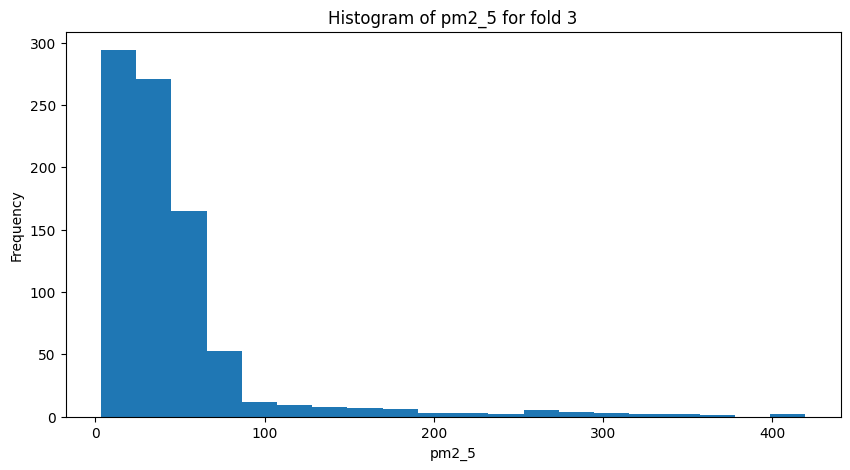

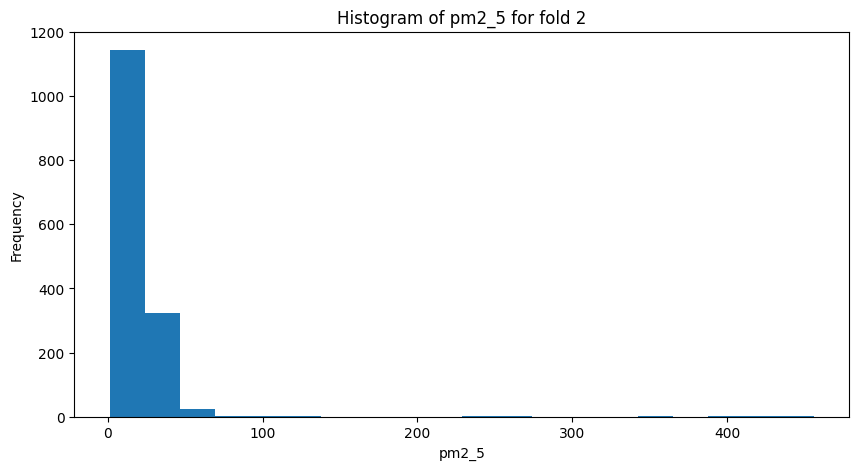

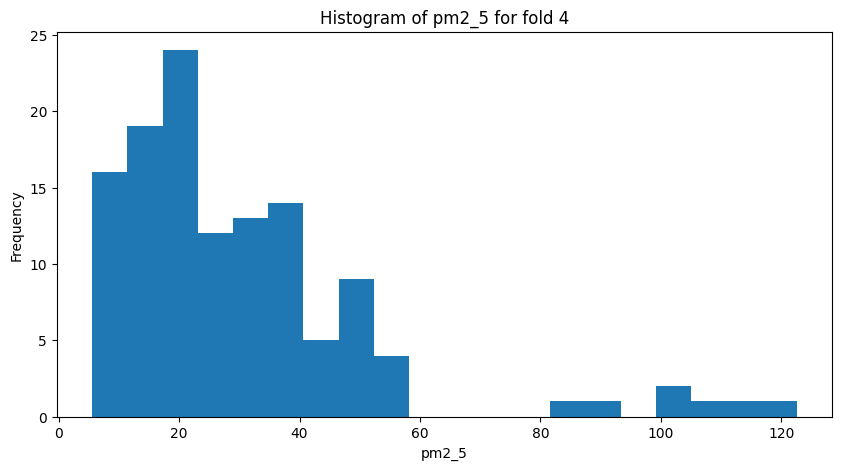

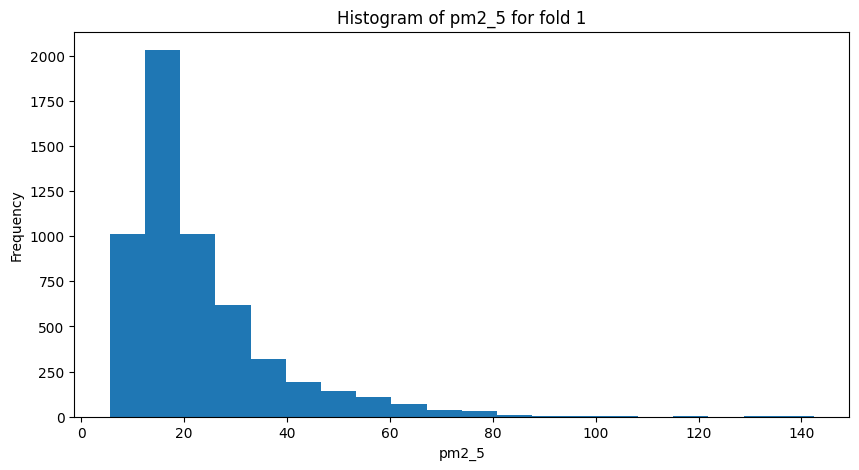

In [9]:
import matplotlib.pyplot as plt

for fold in train['folds'].unique():
    plt.figure(figsize=(10, 5))
    plt.hist(train[train['folds'] == fold]['pm2_5'], bins=20)
    plt.title(f'Histogram of pm2_5 for fold {fold}')
    plt.xlabel('pm2_5')
    plt.ylabel('Frequency')
    plt.show()


## Missing Value Imputation

Impute missing values using forward and backward fill methods.


In [10]:
def forward_fill(df, cols, date_col):
  for col in cols:
    df[col] = df.groupby(date_col)[col].transform(lambda x: x.fillna(method='ffill'))
  return df

def back_fill(df, cols, date_col):
  for col in cols:
    df[col] = df.groupby(date_col)[col].transform(lambda x: x.fillna(method='bfill'))
  return df

for fold in train['folds'].unique():
  train_fold = train[train['folds'] == fold]
  test_fold = test.copy()

  # Identify columns with missing values
  cols_with_missing = train_fold.columns[train_fold.isnull().any()]

  # Forward fill missing values
  train_fold = forward_fill(train_fold, cols_with_missing, 'date')
  test_fold = forward_fill(test_fold, cols_with_missing, 'date')

  # Back fill missing values
  train_fold = back_fill(train_fold, cols_with_missing, 'date')
  test_fold = back_fill(test_fold, cols_with_missing, 'date')

  # Update the train and test sets
  train.update(train_fold)
  test.update(test_fold)

## Feature Engineering

Create new features and perform label encoding.


In [11]:
def feature_engineering(train,test):
    le = LabelEncoder()
    data = pd.concat([train, test])
    data['location'] = data['site_latitude'].astype('str') + '_' + data['site_longitude'].astype('str')

    data = data.sort_values(by = ['city','location', 'date', 'hour'])
    categorical_cols = data.select_dtypes(include='object').columns.tolist()
    high_cardinality = ['site_id']
    low_cardinality = ['city', 'country']
    categorical_cols.remove('date')
    date_cols = ['date']
    numerical_cols = data.select_dtypes(exclude='object').columns.tolist()

    #fill in missing values BY grouping using the cities
    nan_cols = [col for col in numerical_cols if data[col].isnull().sum()>0 and col not in [Config.target_col, "folds"]]
    for col in nan_cols:
        data[col].fillna(data[["location","city", col]].groupby(["city","location"]).shift(periods=0).fillna(method='ffill', limit=1).fillna(method='bfill', limit=1)[col], inplace=True)

    #get date features
    for col in date_cols:
        data[col] = pd.to_datetime(data[col])
        data['month'] = data['date'].dt.month
        data['year'] = data['date'].dt.year
        data['quarter'] = data['date'].dt.quarter
        data['day'] = data['date'].dt.day
        data['week'] = data['date'].dt.isocalendar().week


    #label encode the cat features
    for col in high_cardinality + date_cols + ['location']:
        data[col] = le.fit_transform(data[col])


#     data = pd.get_dummies(data , columns = low_cardinality, drop_first= True, dtype=float)
    independent_features = [col for col in data.columns if col not in [Config.target_col, Config.id_col, 'folds', 'country', 'city','site_id','site_latitude','site_longitude' ]]
    dependent_feature = Config.target_col

    train  = data[data['id'].isin(train['id'].unique())]
    test = data[data['id'].isin(test['id'].unique())]

    return train, test, independent_features, dependent_feature

train_df, test_df, independent_features, dependent_feature = feature_engineering(train, test)

## Modeling: Stage 1

Train the CatBoost model using the created folds.


In [12]:
training  = train_df[train_df['folds'].isin([1.0,4.0, 3.0])]

validation = train_df[train_df['folds'].isin([2.0])]
training.shape, validation.shape

((6571, 79), (1500, 79))

In [13]:
model = catt.CatBoostRegressor(random_state = 42, eval_metric = 'RMSE')
model.fit(training[independent_features], training[dependent_feature], eval_set = (validation[independent_features], validation[dependent_feature]), verbose = 100, early_stopping_rounds = 250 )

Learning rate set to 0.068433
0:	learn: 24.2983927	test: 25.8706263	best: 25.8706263 (0)	total: 70.3ms	remaining: 1m 10s
100:	learn: 12.5677857	test: 24.8848818	best: 24.8843052 (97)	total: 1.14s	remaining: 10.1s
200:	learn: 9.5415921	test: 24.8669852	best: 24.8372444 (157)	total: 2.19s	remaining: 8.71s
300:	learn: 8.1693951	test: 24.9349666	best: 24.8372444 (157)	total: 3.29s	remaining: 7.64s
400:	learn: 7.3759366	test: 24.9685322	best: 24.8372444 (157)	total: 4.33s	remaining: 6.47s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 24.8372444
bestIteration = 157

Shrink model to first 158 iterations.


#### Visualize feature importance

In [14]:
#define a function to create variable importance dataframe
def get_catt_varimp(model, train_columns, max_vars=350):

    # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted,
    # so using feature_importances_ property
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]

    return cv_varimp_df
#
get_catt_varimp(model, independent_features)

,feature_name,varimp (%)
66,location,59.23048
12,carbonmonoxide_co_column_number_density,8.058968
0,date,3.76018
50,ozone_cloud_fraction,2.020766
23,nitrogendioxide_no2_slant_column_number_density,1.328679
53,ozone_solar_azimuth_angle,1.313588
70,week,1.279133
18,carbonmonoxide_solar_azimuth_angle,1.169987
44,uvaerosolindex_solar_azimuth_angle,1.15866
3,sulphurdioxide_so2_column_number_density_amf,1.044047


## Selecting Important Features

Filter non-zero important features and drop highly correlated ones.

In [15]:
feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
cv_varimp_df = pd.DataFrame([independent_features, feature_importances_perc]).T
non_zero_features = cv_varimp_df[cv_varimp_df[1]> 0][0].values
non_zero_features

array(['date', 'hour', 'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction',
       'sulphurdioxide_sensor_azimuth_angle',
       'sulphurdioxide_sensor_zenith_angle',
       'sulphurdioxide_solar_azimuth_angle',
       'sulphurdioxide_solar_zenith_angle',
       'sulphurdioxide_so2_column_number_density_15km', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_azimuth_angle',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_azimuth_angle',
       'carbonmonoxide_solar_zenith_angle',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_density',
       'nitrogendioxide_stratospheric_no2_column_number_density',


In [16]:
len(non_zero_features)

71

#### Dropping highly correlated features

In [17]:
corr = training[non_zero_features].corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = training[non_zero_features].columns[columns]
selected_columns

Index(['date', 'hour', 'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle',
       'sulphurdioxide_sensor_zenith_angle',
       'sulphurdioxide_solar_azimuth_angle',
       'sulphurdioxide_solar_zenith_angle', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_azimuth_angle',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_zenith_angle',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_stratospheric_no2_column_number_density',
       'nitrogendioxide_no2_slant_column_number_density',
       'nitrogendioxide_tropopause_pressure',
       'nitrogendioxide_absorbing_aerosol_index',
       'nitrogendioxide_cloud_fraction',
       'nitrogendioxide_sensor_azim

In [18]:
len(selected_columns)

46

## Cross-Validation and Model Evaluation

Perform cross-validation and evaluate the model performance.


In [19]:
fold_pred = []
oof_pred = []

for fold in [1,2,3,4]:
    print("*" * 100)
    train_df[dependent_feature] = np.where(train_df[dependent_feature] >= train_df[dependent_feature].quantile(0.97), train_df[dependent_feature].quantile(0.97), train_df[dependent_feature])

    training = train_df[train_df['folds'] != fold]
    validation = train_df[train_df['folds'] == fold]



    #training and evaluation
    y_train = training[dependent_feature]
    y_test = validation[dependent_feature]

    X_train = training[selected_columns]
    X_test = validation[selected_columns]

    model = catt.CatBoostRegressor(random_state = 42, eval_metric = 'RMSE')
    model.fit(X_train, y_train, eval_set = (X_test, y_test), verbose = 100, early_stopping_rounds = 250 )

    preds = model.predict(X_test)
    print(f"RMSE for fold :{fold} : {(mean_squared_error(preds, y_test, squared=False))}")
    oof_pred.append(mean_squared_error(preds, y_test, squared=False))

    #Inference
    test_preds = model.predict(test_df[selected_columns])
    fold_pred.append(test_preds)



print(f"The average rmse across the 4 groups: {np.mean(oof_pred)}")



****************************************************************************************************
Learning rate set to 0.058707
0:	learn: 16.5497466	test: 13.1196721	best: 13.1196721 (0)	total: 10ms	remaining: 10s
100:	learn: 8.6415516	test: 12.2130378	best: 12.0829675 (50)	total: 638ms	remaining: 5.68s
200:	learn: 6.6753071	test: 12.5087566	best: 12.0829675 (50)	total: 1.28s	remaining: 5.07s
300:	learn: 5.4873002	test: 12.6491085	best: 12.0829675 (50)	total: 1.9s	remaining: 4.42s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 12.08296751
bestIteration = 50

Shrink model to first 51 iterations.
RMSE for fold :1 : 12.082967288611616
****************************************************************************************************
Learning rate set to 0.068433
0:	learn: 14.4437105	test: 13.1401303	best: 13.1401303 (0)	total: 9.09ms	remaining: 9.07s
100:	learn: 8.2409326	test: 11.0850785	best: 11.0850785 (100)	total: 748ms	remaining: 6.66s
200:	learn: 6.8337983	te

#### Submission

In [20]:
test.shape

(2783, 72)

In [21]:
pred = np.mean(fold_pred, axis = 0)
len(pred)
test_df['pred'] = pred
sub = test_df[['id', 'pred']]
sub.head()

,id,pred
214,id_yorywxet0a,22.633410
215,id_9rhbkh8kye,20.543943
216,id_oh2pg7ik9m,20.126874
217,id_u5xtrnbshq,22.017378
218,id_pfcdhqpggy,17.442497


In [22]:
sub.to_csv('submission.csv', index= False)